# **2. Neural Network**


> This code is adapted from course **NN from Zero to Hero** - Andrej Karpathy

- We want to create a neuron (a unit of Neural Network or a perceptron) and  Neural Network (or Multi Layer Perceptron)

In [1]:
# Run this library
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline

In [2]:
def trace(root):
    """Trace all noeds and edges in a graph"""
    nodes = set()
    edges = set()

    # A local function
    def build(node):
        # If node is not in nodes, then trace the node
        if node not in nodes:
            # Store node to nodes
            nodes.add(node)

            # Iterate to find child of previous nodes
            for child in node._prev:
                # Add edges that connect node & child
                edges.add((child, node))

                # Build the child node recursively
                build(child)

    # Start building the node recursively from the final node
    build(root)

    return nodes, edges

def draw_dot(root):
    """Draw the computational graph by backtracing the operation"""
    # Create a workspace
    dot = Digraph(format='svg',
                  graph_attr={'rankdir': 'LR'})

    # Trace the nodes & edges from computational graph
    nodes, edges = trace(root)

    # Draw
    for node_ in nodes:
        uid = str(id(node_))

        # Create a rectangular node
        # ADD GRAD RESULTS in here
        dot.node(name = uid,
                 label = '{ %s | data %.4f | grad %.4f }' % (node_.label, node_.data, node_.grad),
                 shape = 'record')

        # Create operator (node & edge)
        if node_._op:
            # Create an operation node
            dot.node(name = uid + node_._op,
                     label = node_._op)

            # Connect edge between operation nodes to next value nodes
            dot.edge(tail_name = uid + node_._op,
                     head_name = uid)

    # Create edge for value nodes to operation nodes
    for node_1, node_2 in edges:
        dot.edge(tail_name = str(id(node_1)),
                 head_name = str(id(node_2)) + node_2._op)

    return dot


## **Task 1**
---

- Update the previous `Value` Class
- Add
  - Power operation method
  - Negation operation method, e.g. substraction, division
  - Input defense on each numerical operation method
  - Enabling the class to operate with scalar value, e.g.
    - `3 + Value(4)`
    - `4 * Value(5)`

In [3]:
# Write your code here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        # Asser other type
        other = other if isinstance(other, Value) else Value(other)

        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        # Asser other type
        other = other if isinstance(other, Value) else Value(other)

        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad += other.data * out.grad

            # This is dC / dB = A
            other.grad += self.data * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __pow__(self, other):
        # Asser other type
        assert isinstance(other, (int, float)), "Only support int/float powers"

        out = Value(data = self.data**other,
                    _children = (self,),
                    _op = f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        # For other + Value()
        return self + other

    def __rmul__(self, other):
        # For other * Value()
        return self * other

    def __truediv__(self, other):
        # For Value() / other
        return self * (other**-1)

    def __neg__(self):
        # For -Value()
        return self * -1

    def __sub__(self, other):
        # For Value() - other
        return self + (-other)

    def __rsub__(self, other):
        # For other - Value()
        return other + (-self)

    def backward(self):
        # Initialize
        topo = []
        visited = set()

        # create a function to build topology recursively
        def build_topo(node):
            if node not in visited:
                # add node
                visited.add(node)

                # visit child recursively
                for child in node._prev:
                    build_topo(child)

                # append node to topo
                topo.append(node)

        # Run the build_topo
        build_topo(node = self)

        # Run the backward operation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Test the code

In [4]:
a = Value(data=3.0, label='a')
b = Value(data=4.0, label='b')

# Perform calculation
print(3 + a)        # should be 6
print(b / 2)        # should be 2
print(4 - b)        # should be 0

Value(data=6.0)
Value(data=2.0)
Value(data=0.0)


In [5]:
c = 8 - b; c.label='c'
d = c**2; d.label='d'

print(d)

Value(data=16.0)


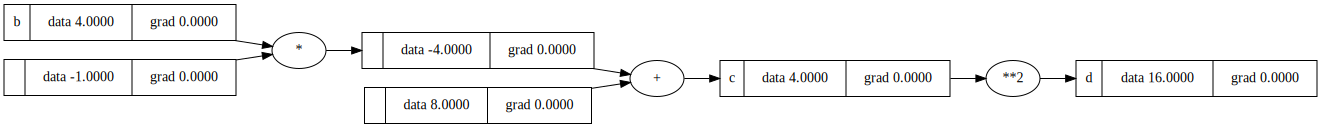

In [6]:
draw_dot(d)

## **Task 2**
---

- Update `Value` class to have some activation function operations & its derivative, i.e.
  - Exp
  - Sigmoid
  - TanH

**Exponential**

- The formula
$$
y = \exp(x)
$$

- The derivative
$$
\cfrac{\partial \ y}{\partial x} = \exp(x)
$$

**Sigmoid**

- The formula
$$
\sigma(x) = \cfrac{\exp(x)}{\exp(x)+1}
$$

- The derivative
$$
\cfrac{\partial \ \sigma(x)}{\partial x} = \sigma(x) (1 - \sigma(x))
$$

**Tanh**

- The formula
$$
\tanh(x) = \cfrac{\exp(2x) - 1}{\exp(2x) + 1}
$$

- The derivative
$$
\cfrac{\partial \ \tanh(x)}{\partial x} = 1 - \tanh^{2}(x)
$$

In [7]:
# Write your code here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        # Asser other type
        other = other if isinstance(other, Value) else Value(other)

        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        # Asser other type
        other = other if isinstance(other, Value) else Value(other)

        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad += other.data * out.grad

            # This is dC / dB = A
            other.grad += self.data * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __pow__(self, other):
        # Asser other type
        assert isinstance(other, (int, float)), "Only support int/float powers"

        out = Value(data = self.data**other,
                    _children = (self,),
                    _op = f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        # For other + Value()
        return self + other

    def __rmul__(self, other):
        # For other * Value()
        return self * other

    def __truediv__(self, other):
        # For Value() / other
        return self * (other**-1)

    def __neg__(self):
        # For -Value()
        return self * -1

    def __sub__(self, other):
        # For Value() - other
        return self + (-other)

    def __rsub__(self, other):
        # For other - Value()
        return other + (-self)

    def exp(self):
        """return exp(self)"""
        x = self.data
        out = Value(data = math.exp(x),
                    _children = (self,),
                    _op = 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def sigmoid(self):
        """return sigmoid(self)"""
        x = self.data
        exp_x = math.exp(x)
        sigmoid_x = exp_x / (exp_x + 1.)
        out = Value(data = sigmoid_x,
                    _children = (self,),
                    _op = 'sigmoid')

        def _backward():
            self.grad += (sigmoid_x) * (1 - sigmoid_x) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        """return tanh(self)"""
        x = self.data
        exp_2x = math.exp(2*x)
        tanh_x = (exp_2x - 1.) / (exp_2x + 1.)
        out = Value(data = tanh_x,
                    _children = (self,),
                    _op = 'tanh')

        def _backward():
            self.grad += (1 - tanh_x**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Initialize
        topo = []
        visited = set()

        # create a function to build topology recursively
        def build_topo(node):
            if node not in visited:
                # add node
                visited.add(node)

                # visit child recursively
                for child in node._prev:
                    build_topo(child)

                # append node to topo
                topo.append(node)

        # Run the build_topo
        build_topo(node = self)

        # Run the backward operation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Test the code

In [8]:
# Simple test
a = Value(data=1.0, label='a')

print(a.exp())      # It should be 2.718
print(a.tanh())     # It should be 0.762
print(a.sigmoid())  # It should be 0.731

Value(data=2.718281828459045)
Value(data=0.7615941559557649)
Value(data=0.7310585786300049)


In [9]:
# A simple Neuron with TanH activation function
x1 = Value(data=2.0, label='x1')
x2 = Value(data=0.0, label='x2')
w1 = Value(data=-3.0, label='w1')
w2 = Value(data=1.0, label='w2')
b = Value(data=6.88, label='b')

n = x1*w1 + x2*w2 + b; n.label='pre'
o = n.tanh(); o.label='o'

print(o)    # should be 0.707

Value(data=0.7064193203972352)


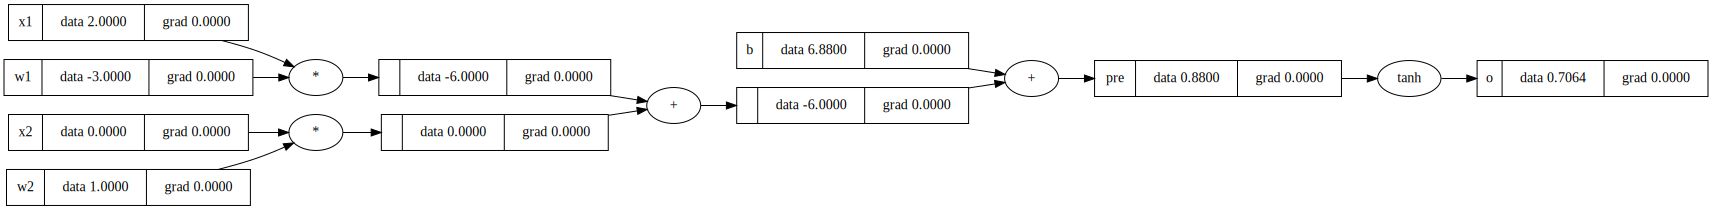

In [10]:
draw_dot(o)

## **Task 3**
---

- Create a `Neuron` class using `Value` class.
- Remember a Neuron has:
  - Several inputs
  - An activation functions
  - An output

<center>
<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*O7YSSqlOdQuNgMrH7J_3dg.png">
<br>
<a href="https://medium.com/analytics-vidhya/neural-network-part1-inside-a-single-neuron-fee5e44f1e">image source</a>

- Your `Neuron` class should
  - Initialize weight & bias randomly based on number of input when initialize
  - If we call the `Neuron` object, you should return the activation function value, or $\hat{y}$ based on the figure above.
  - Has `parameters` method and return the parameter of that neuron

In [11]:
# Write your code here
class Neuron:
    """Simple Neuron class"""
    def __init__(self, n_in):
        """
        We initialize the Neuron weights & biases
            based on the number of input (n_in).

        The weights & biases are generate randomly between [-1, 1]

        Parameters
        ----------
        n_in : int
            The number of input
        """
        # Initialize the Neuron parameters (w & b)
        self.w = [Value(data=random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(data=random.uniform(-1, 1))

    def __call__(self, x):
        """
        Return the activation value

        Parameters:
        -----------
        x : list
            The input of 1D list
        """
        # Calculate the pre-activation value
        linear_sum = sum([wi*xi for wi, xi in zip(self.w, x)])
        pre_act = linear_sum + self.b

        # Calculate the activation value
        # Assumed we use a TanH activation function
        out = pre_act.tanh()

        return out

    def parameters(self):
        """Return the Neuron parameters"""
        return self.w + [self.b]


Test the code

In [12]:
# A neuron that has 3 inputs
n_in = 3

mdl = Neuron(n_in = n_in)
mdl

In [13]:
# Feed the input & return the Neuron output
x = [0.1, 0.5, 1.0]
mdl(x)

Value(data=-0.13875684858873008)

In [14]:
# Extract the weight & biases
mdl.parameters()

[Value(data=-0.9959667388917455),
 Value(data=-0.7051018668187641),
 Value(data=-0.44240859800775745),
 Value(data=0.7548984091535678)]

In [15]:
# Validate
w = mdl.parameters()[:3]
b = mdl.parameters()[-1]

w, b

([Value(data=-0.9959667388917455),
  Value(data=-0.7051018668187641),
  Value(data=-0.44240859800775745)],
 Value(data=0.7548984091535678))

In [16]:
# Manually calculate the output
pre_act_val = sum([wi*xi for wi, xi in zip(w, x)]) + b
print('Pre-activation value :', pre_act_val)

output = pre_act_val.tanh()
print('Output               :', output)

Pre-activation value : Value(data=-0.13965779615274632)
Output               : Value(data=-0.13875684858873008)


## **Task 4**
---

- Create a `Layer` class using `Value` class.
- Remember a Layer has:
  - Several number of input
  - Several number of Neurons
  - Several number of output
  - **Number of neuron** equals to number of output

<center>
<img src="https://lucidar.me/en/neural-networks/files/single-layer-architecture.png">
<br>
<a href="https://lucidar.me/en/neural-networks/single-layer-algorithm/">image source</a>

- The `Layer` class:
  - Initialize by defining the number of input, `n_in`, and the number of output, `n_out`.
  - If the `Layer` object is called, return the outputs value from each Neuron inside the layers.
  - Create a method called by `parameters()` that return the stacked of model parameters from the first to last Neuron in series.

In [17]:
# Write your code here
class Layer:
    def __init__(self, n_in, n_out):
        """
        Create a set of Neuron that has n_in input & n_out output

        Parameters
        ----------
        n_in : int
            Number of input in each Neuron

        n_out : int
            Number of output
            This decide the number of Neuron.
            Remember, 1 neuron = 1 output
        """
        self.neurons = [Neuron(n_in=n_in) for _ in range(n_out)]

    def __call__(self, x):
        """return the output of layers"""
        # The output should be a list if n_out > 1
        outs = [neuron(x) for neuron in self.neurons]
        if len(outs) == 1:
            return outs[0]
        else:
            return outs

    def parameters(self):
        """return the Layer parameters"""
        neuron_params = [neuron.parameters() for neuron in self.neurons]
        layer_params = []
        for param in neuron_params:
            layer_params.extend(param)

        return layer_params


Test your code!

In [18]:
# Create a layer that predict multi-classes output
#   e.g. predict digit, 0..9
# with 4 input
mdl = Layer(n_in = 4,
            n_out = 10)

mdl

In [19]:
# Feed the input & return the Neuron output
x = [0.1, 0.5, 1.0, -0.75]
mdl(x)

[Value(data=-0.9182006574644115),
 Value(data=0.8933270662162326),
 Value(data=0.87601959171595),
 Value(data=0.7538908393729976),
 Value(data=0.30531431058679354),
 Value(data=0.4391964148472784),
 Value(data=-0.8043363698153555),
 Value(data=0.5932625753088295),
 Value(data=-0.7728571826267966),
 Value(data=0.4097265650739636)]

In [20]:
# Extract the weight & biases
mdl.parameters()

[Value(data=0.7901630858545579),
 Value(data=-0.21001694949264582),
 Value(data=-0.2837674383437885),
 Value(data=0.997382883775485),
 Value(data=-0.5196400636289031),
 Value(data=-0.8839749357801598),
 Value(data=0.7328607608444535),
 Value(data=0.03754596385689557),
 Value(data=-0.3465377802725844),
 Value(data=0.8626795407554695),
 Value(data=-0.9356350112669156),
 Value(data=-0.16361559247809443),
 Value(data=0.6235985895676637),
 Value(data=-0.07579632311114026),
 Value(data=0.8533174741868288),
 Value(data=-0.5175350237585175),
 Value(data=-0.5871383283542584),
 Value(data=0.09799842882837706),
 Value(data=-0.697752017849911),
 Value(data=0.7059186022633079),
 Value(data=-0.6967005857367541),
 Value(data=-0.6753573599657581),
 Value(data=-0.45491674449560127),
 Value(data=-0.5972482473793346),
 Value(data=0.7296991194970808),
 Value(data=0.10753953237848912),
 Value(data=0.815541784717666),
 Value(data=-0.778405650984541),
 Value(data=-0.36003601150965636),
 Value(data=0.56108852

In [21]:
# Validate the first neuron
# 1st neuron has 4 weights + 1 bias
w = mdl.parameters()[:4]
b = mdl.parameters()[4]

w, b

([Value(data=0.7901630858545579),
  Value(data=-0.21001694949264582),
  Value(data=-0.2837674383437885),
  Value(data=0.997382883775485)],
 Value(data=-0.5196400636289031))

In [22]:
# Manually calculate the output
pre_act_val = sum([wi*xi for wi, xi in zip(w, x)]) + b
print('Pre-activation value :', pre_act_val)

output = pre_act_val.tanh()
print('Output               :', output)

Pre-activation value : Value(data=-1.5774368309651725)
Output               : Value(data=-0.9182006574644115)


In [23]:
# Output of the first neuron
mdl(x)[0]

Value(data=-0.9182006574644115)

## **Task 5**
---

- Create a `MLP` (multi-layer perceptron or neural network) class using `Value` class.
- Remember an MLP has:
  - Several number of input
  - Several number of layers
  - Several number of output

<center>
<img src = "https://www.researchgate.net/publication/354817375/figure/fig2/AS:1071622807097344@1632506195651/Multi-layer-perceptron-MLP-NN-basic-Architecture.jpg">
<br>
<a href="https://www.researchgate.net/publication/354817375_Modeling_the_fluctuations_of_groundwater_level_by_employing_ensemble_deep_learning_techniques">image source</a>

- In `MLP` class:
  - Initialize the object by stating the number of input & outputs of each "hidden" layer.
  - Return the MLP output if the object is called.
  - Return all parameters from the first to last "hidden" layer by calling `parameters()` method.

In [24]:
# Write your code here
class MLP:
    def __init__(self, n_in, n_outs):
        """
        Initialize the MLP layers

        Parameters
        ----------
        n_in : int
            Number of input

        n_outs : list
            The size (number of output) of each hidden layers
        """
        sizes = [n_in] + n_outs
        self.layers = []
        for i in range(len(n_outs)):
            layer_i = Layer(n_in = sizes[i],
                            n_out = sizes[i+1])
            self.layers.append(layer_i)

    def __call__(self, x):
        """Return the MLP predictions"""
        for layer in self.layers:
            # re-assign the input from previous layer outputs
            x = layer(x)

        return x

    def parameters(self):
        """Return all parameters"""
        layer_params = [layer.parameters() for layer in self.layers]
        mlp_params = []
        for layer in layer_params:
            mlp_params.extend(layer)

        return mlp_params


Test your code!

In [25]:
# Create an MLP with
# - 4 inputs
# - 2 hidden layers (1st size 5, 2nd size 3)
# - 2 outputs
mdl = MLP(n_in = 4,
          n_outs = [5, 3, 2])

In [26]:
# Feed the input & return the Neuron output
x = [0.1, 0.5, 1.0, -0.75]
mdl(x)

[Value(data=0.517916350065872), Value(data=0.228851312540066)]

In [27]:
# Extract the weight & biases
mdl.parameters()

[Value(data=0.7562739965751784),
 Value(data=0.921210834872475),
 Value(data=0.16663005483323978),
 Value(data=-0.2311613687966949),
 Value(data=0.011447643338688307),
 Value(data=0.19711732596051235),
 Value(data=-0.3509409066607152),
 Value(data=0.22911305605969012),
 Value(data=0.8243610343525363),
 Value(data=-0.7130402250745829),
 Value(data=0.7709103240959729),
 Value(data=-0.16794483939393245),
 Value(data=0.07994484037251226),
 Value(data=-0.9652582660195621),
 Value(data=0.2612009277945393),
 Value(data=0.1574348361042004),
 Value(data=0.879147226287355),
 Value(data=0.46031213537443083),
 Value(data=0.9751419493338436),
 Value(data=-0.28076062770107235),
 Value(data=0.9850121599416821),
 Value(data=0.16320544932406889),
 Value(data=-0.25946256565691717),
 Value(data=0.782499779963981),
 Value(data=-0.20591834124335606),
 Value(data=-0.6472848995642604),
 Value(data=-0.4964953235879812),
 Value(data=-0.5297789616954245),
 Value(data=0.595858296228192),
 Value(data=-0.480691853

## **Task 6**
---

- Your task is to train a single Neuron.
- Remember, a single Neuron has a capability similar to a Linear Regression or Logistic Regression
- We will use a gradient descent to train the Neuron

<center>

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning2.png">
<br>
<a href="https://www.javatpoint.com/gradient-descent-in-machine-learning">image source</a>

- In gradient descent, the weights & biases are updated iteratively

$$
w^{(\text{new})}_{j} := w^{(\text{old})}_{j} - \mu \cfrac{\partial \ \text{Loss}}{\partial \ w_{j}}
$$

- Let's model a classification task

In [28]:
# The input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [29]:
# Create model
mdl = Neuron(n_in = 3)
mdl

In [30]:
def mse(y_true, y_pred):
    """return a mean squared error predictions"""
    losses = [(yt-yp)**2 for yt, yp in zip(y_true, y_pred)]
    mean_loss = sum(losses) / len(y_true)
    return mean_loss

In [31]:
# Let's do the gradient descent
for k in range(1000):
    # Do the forward pass
    y_pred = [mdl(x) for x in xs]

    # Calculate the loss
    loss = mse(y_true=ys, y_pred=y_pred)

    # Do the backward pass
    # No need to manually compute the derivative of loss
    # Always set the grad to 0.0 in every iteration
    for model_param in mdl.parameters():
        model_param.grad = 0.0

    # Do the backward
    loss.backward()

    # Update the model parameters using gradient descent
    learning_rate = 0.1
    for model_param in mdl.parameters():
        model_param.data += -learning_rate * model_param.grad

    if k%50 == 0 or k==1000-1:
        print(f'iter: {k}, MSE loss: {loss.data:.4f}')

iter: 0, MSE loss: 2.6921
iter: 50, MSE loss: 0.0164
iter: 100, MSE loss: 0.0074
iter: 150, MSE loss: 0.0047
iter: 200, MSE loss: 0.0035
iter: 250, MSE loss: 0.0028
iter: 300, MSE loss: 0.0023
iter: 350, MSE loss: 0.0019
iter: 400, MSE loss: 0.0017
iter: 450, MSE loss: 0.0015
iter: 500, MSE loss: 0.0013
iter: 550, MSE loss: 0.0012
iter: 600, MSE loss: 0.0011
iter: 650, MSE loss: 0.0010
iter: 700, MSE loss: 0.0009
iter: 750, MSE loss: 0.0009
iter: 800, MSE loss: 0.0008
iter: 850, MSE loss: 0.0008
iter: 900, MSE loss: 0.0007
iter: 950, MSE loss: 0.0007
iter: 999, MSE loss: 0.0007


In [32]:
# Let's predict
y_pred_final = [mdl(x).data for x in xs]

print(f'True value      :', ys)
print(f'Predicted value :', y_pred_final)
print(f'Final loss      :', mse(ys, y_pred_final))

True value      : [1.0, -1.0, -1.0, 1.0]
Predicted value : [0.9835340715740074, -0.9850154460264454, -0.9627533541457491, 0.9725014396560449]
Final loss      : 0.0006597867762746017


Great!

## **Task 7**
---

- Now your task is to train a single layer

In [33]:
# Create model
mdl = Layer(n_in = 3, n_out = 1)
mdl

In [34]:
# Let's do the gradient descent
for k in range(1000):
    # Do the forward pass
    y_pred = [mdl(x) for x in xs]

    # Calculate the loss
    loss = mse(y_true=ys, y_pred=y_pred)

    # Do the backward pass
    # No need to manually compute the derivative of loss
    # Always set the grad to 0.0 in every iteration
    for model_param in mdl.parameters():
        model_param.grad = 0.0

    # Do the backward
    loss.backward()

    # Update the model parameters using gradient descent
    learning_rate = 0.1
    for model_param in mdl.parameters():
        model_param.data += -learning_rate * model_param.grad

    if k%50 == 0 or k==1000-1:
        print(f'iter: {k}, MSE loss: {loss.data:.4f}')

iter: 0, MSE loss: 2.5533
iter: 50, MSE loss: 0.0375
iter: 100, MSE loss: 0.0111
iter: 150, MSE loss: 0.0064
iter: 200, MSE loss: 0.0045
iter: 250, MSE loss: 0.0034
iter: 300, MSE loss: 0.0028
iter: 350, MSE loss: 0.0023
iter: 400, MSE loss: 0.0020
iter: 450, MSE loss: 0.0017
iter: 500, MSE loss: 0.0016
iter: 550, MSE loss: 0.0014
iter: 600, MSE loss: 0.0013
iter: 650, MSE loss: 0.0012
iter: 700, MSE loss: 0.0011
iter: 750, MSE loss: 0.0010
iter: 800, MSE loss: 0.0009
iter: 850, MSE loss: 0.0009
iter: 900, MSE loss: 0.0008
iter: 950, MSE loss: 0.0008
iter: 999, MSE loss: 0.0007


In [35]:
# Let's predict
y_pred_final = [mdl(x).data for x in xs]

print(f'True value      :', ys)
print(f'Predicted value :', y_pred_final)
print(f'Final loss      :', mse(ys, y_pred_final))

True value      : [1.0, -1.0, -1.0, 1.0]
Predicted value : [0.9958634388239777, -0.9825398147381808, -0.964026860776831, 0.9635360904405088]
Final loss      : 0.0007364131634180701


## **Task 8**
---

- Train an MLP

In [36]:
# Create model
mdl = MLP(n_in = 3, n_outs = [2, 2, 1])
mdl

In [37]:
# Let's do the gradient descent
for k in range(1000):
    # Do the forward pass
    y_pred = [mdl(x) for x in xs]

    # Calculate the loss
    loss = mse(y_true=ys, y_pred=y_pred)

    # Do the backward pass
    # No need to manually compute the derivative of loss
    # Always set the grad to 0.0 in every iteration
    for model_param in mdl.parameters():
        model_param.grad = 0.0

    # Do the backward
    loss.backward()

    # Update the model parameters using gradient descent
    learning_rate = 0.1
    for model_param in mdl.parameters():
        model_param.data += -learning_rate * model_param.grad

    if k%50 == 0 or k==1000-1:
        print(f'iter: {k}, MSE loss: {loss.data:.4f}')

iter: 0, MSE loss: 1.4194
iter: 50, MSE loss: 0.0192
iter: 100, MSE loss: 0.0081
iter: 150, MSE loss: 0.0050
iter: 200, MSE loss: 0.0036
iter: 250, MSE loss: 0.0029
iter: 300, MSE loss: 0.0023
iter: 350, MSE loss: 0.0020
iter: 400, MSE loss: 0.0017
iter: 450, MSE loss: 0.0015
iter: 500, MSE loss: 0.0014
iter: 550, MSE loss: 0.0012
iter: 600, MSE loss: 0.0011
iter: 650, MSE loss: 0.0010
iter: 700, MSE loss: 0.0010
iter: 750, MSE loss: 0.0009
iter: 800, MSE loss: 0.0008
iter: 850, MSE loss: 0.0008
iter: 900, MSE loss: 0.0007
iter: 950, MSE loss: 0.0007
iter: 999, MSE loss: 0.0007


In [38]:
# Let's predict
y_pred_final = [mdl(x).data for x in xs]

print(f'True value      :', ys)
print(f'Predicted value :', y_pred_final)
print(f'Final loss      :', mse(ys, y_pred_final))

True value      : [1.0, -1.0, -1.0, 1.0]
Predicted value : [0.9792016757378268, -0.9816064172348523, -0.9677122841710839, 0.9716079631492043]
Final loss      : 0.0006548746322596555


This is a great result!

## **Exercise**
---

- Train a neural network to solve the XOR Problem

<center>

<img src="https://media2.dev.to/dynamic/image/width=1000,height=420,fit=cover,gravity=auto,format=auto/https%3A%2F%2Fdev-to-uploads.s3.amazonaws.com%2Fi%2Flkli02223oqhlac1jetz.png">
<br>
<a href="https://dev.to/jbahire/demystifying-the-xor-problem-1blk">image source</a>

In [39]:
# The input of XOR problem
xs = [
    [1.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 0.0]
]

ys = [-1.0, 1.0, 1.0, -1.0]